In [1]:
import sys
import os
import warnings
import pandas as pd
#warnings.filterwarnings('ignore')
#sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'src/violin/')))

In [30]:
model_file = './input/models/example_model_baseline_GBM_biorecipe_1_8_25_1.xlsx'
reading_file = './input/interactions/indra_output_flute_filtered.xlsx'
out_file = './output/indra_output_flute_filtered_classified'

In [31]:
###Preamble###
%load_ext autoreload
%autoreload 2

from violin.in_out import preprocessing_model,preprocessing_reading,output
from violin.scoring import score_reading
from violin.network import node_edge_list
from violin.visualize_violin import visualize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
###Parameters###
# Choose a classify approach ('1', '2', or '3')
approach = '1' # default is '1'

# Scoring values defined for scheme '1' and '2'
kind_dict = {"strong corroboration" : 2, 
                "empty attribute" : 1,
                "indirect interaction" : 3,
                "path corroboration" : 5,
                "specification" : 7,
                "hanging extension" : 40, 
                "full extension" : 39, 
                "internal extension" : 38,  
                "dir contradiction" : 11,
                "sign contradiction" : 10, 
                "att contradiction" : 9,
                "dir mismatch" : 20,
                "path mismatch" : 19,
                "self-regulation" : 18}

#Scoring values defined for scheme 3
# kind_dict = {"strong corroboration" : 1, 
#                 "weak corroboration1" : 2,
#                 "weak corroboration2" : 3,
#                 "weak corroboration3" : 4,
#                 "hanging extension" : 40, 
#                 "full extension" : 39, 
#                 "internal extension" : 38, 
#                 "specification" : 37, 
#                 "dir contradiction" : 10,
#                 "sign contradiction" : 9,
#                 "att contradiction" : 8,
#                 "flagged1" : 20,
#                 "flagged2" : 19,
#                 "flagged3" : 18,
#                 "flagged4" : 17,
#                 "flagged5" : 16}

match_dict = {"source present" : 1, 
                "target present" : 100, 
                "both present" : 10, 
                "neither present" : 0.1}
# Typically, VIOLIN is using different statements from papers to compute the score of evidence
# To compare if the interactions are identity, we only compare the columns that are not related to statments, confidence score, paper ids, and database source  
evidence_scoring_cols = ["Regulator Name", "Regulator Type", "Regulator Subtype", "Regulator HGNC Symbol", "Regulator Database", "Regulator ID", "Regulator Compartment", "Regulator Compartment ID",
                        "Regulated Name", "Regulated Type", "Regulated Subtype", "Regulated HGNC Symbol", "Regulated Database", "Regulated ID", "Regulated Compartment", "Regulated Compartment ID",
                        "Sign", "Connection Type", "Mechanism", "Site",
                        "Cell Line", "Cell Type", "Tissue Type", "Organism"]

attributes = ['Regulated Compartment ID', 'Regulator Compartment ID']

In [33]:
###_File input and formatting_###
###This assumes the input files match the default input REACH and BioRECIPES formats###

# import model, normalize attributes info of nodes and edges
model_df = preprocessing_model(model_file)
# import interactions, normalize interactions attributes, merge duplicates
reading_df = preprocessing_reading(reading=reading_file, evidence_score_cols=evidence_scoring_cols, atts = attributes)
# Convert the model as a graph
graph = node_edge_list(model_df)

In [34]:
reading_df

,Regulator Name,Regulator Type,Regulator Subtype,Regulator HGNC Symbol,Regulator Database,Regulator ID,Regulator Compartment,Regulator Compartment ID,Regulated Name,Regulated Type,...,Site,Cell Line,Cell Type,Tissue Type,Organism,Score,Source,Statements,Paper IDs,Evidence Score
0,3-methyladenine,chemical,nan,nan,pubchem,1673,nan,nan,bnip3,protein,...,nan,nan,nan,nan,nan,[0.65],[indra],[hypoxic u87 cells had elevated levels of bnip...,[pmc5417003],1
1,a2m,protein,nan,a2m,uniprot,p01023,nan,nan,serpina1,protein,...,nan,nan,nan,nan,nan,[0.65],[indra],[protease inhibitors like alpha-2-macroglobuli...,[pmc5431125],1
2,a2m,protein,nan,a2m,uniprot,p01023,nan,nan,serpinc1,protein,...,nan,nan,nan,nan,nan,[0.65],[indra],[protease inhibitors like alpha-2-macroglobuli...,[pmc5431125],1
3,abcb1,protein,nan,abcb1,uniprot,p08183,nan,nan,wnt3a,protein,...,nan,nan,nan,nan,nan,[0.65],[indra],[temozolomide treated cells had increased meth...,[pmc3813413],1
4,abcg2,protein,nan,abcg2,uniprot,q9unq0,nan,nan,casp3,protein,...,nan,nan,nan,nan,nan,[0.65],[indra],"[in contrast, overxpression of abcg2 reduced c...",[pmc5522142],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3019,zfx,protein,nan,nan,uniprot,p81543,nan,nan,bmx,protein,...,nan,nan,nan,nan,nan,[0.65],[indra],[targeting gsc-derived pericytes through bmx i...,[pmc5687837],1
3020,zfx,protein,nan,zfx,uniprot,p17010,nan,nan,myc,protein,...,nan,nan,nan,nan,nan,[0.65],[indra],[real time pcr analysis confirmed that zfx dis...,[pmc4349564],1
3021,zfx,protein,nan,zfx,uniprot,p17010,nan,nan,myc,protein,...,nan,nan,nan,nan,nan,"[0.65, 0.86]","[indra, indra]",[this finding also suggests the important role...,"[pmc4454553, pmc4349564]",2
3022,zfx,protein,nan,zfx,uniprot,p17010,nan,nan,myc,protein,...,nan,nan,nan,nan,nan,"[0.923, 0.65]","[indra, indra]",[disrupting zfx by shrna reduced c-myc express...,"[pmc4349564, pmc4349564]",2


In [35]:
###_Scoring_###
scored = score_reading(reading_df,model_df,graph,kind_values = kind_dict,match_values = match_dict,attributes = attributes, classify_scheme=approach)

3024


In [36]:
###_Output_###
output(scored,out_file,kind_values=kind_dict)

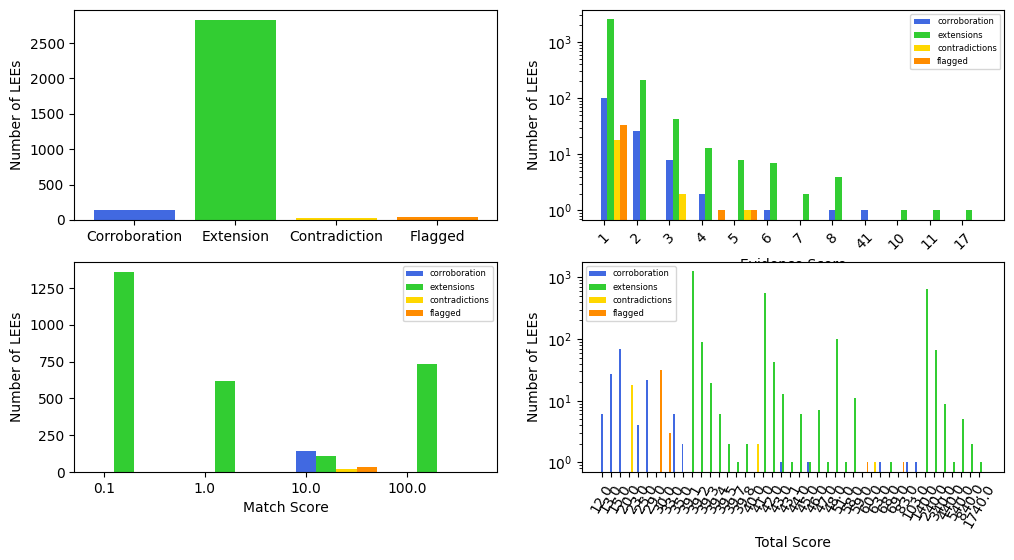

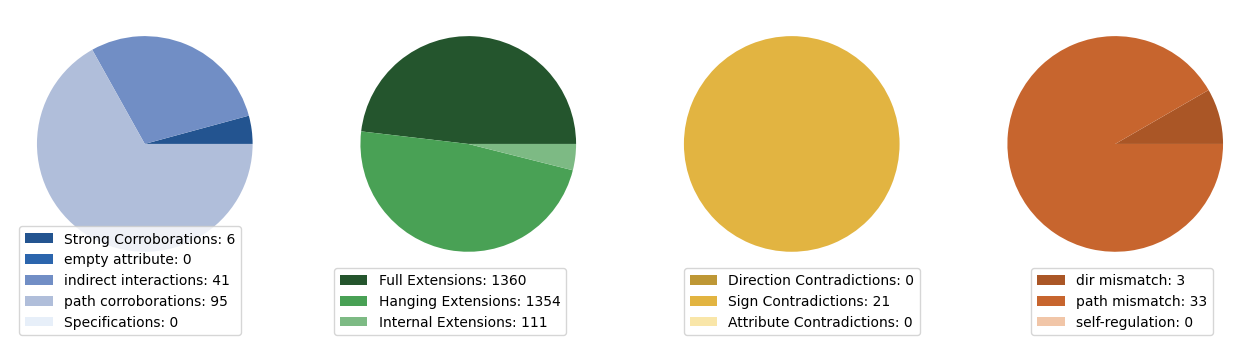

In [37]:
###_Visualization_###
visualize(match_dict, kind_dict, out_file+'_outputDF.csv', filter_opt='100%')